In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import heapq
import geopandas as gpd
import plotly.graph_objects as go
import copy
import geopy
import multiprocessing
from joblib import Parallel, delayed

# Example Graph (from lecture 6)

This uses second example from Lecture 6 and implement LP solution. 

NameError: name 'linprog' is not defined

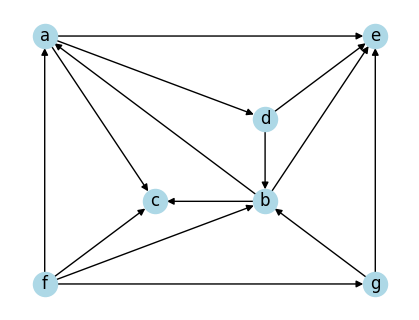

In [2]:
# Define graph
nodes = ['a','b','c','d','e','f','g']
coordinates = {'a':(0,3),'b':(2,1),'c':(1,1),'d':(2,2),'e':(3,3),'f':(0,0),'g':(3,0)}
edges = [('a','c'),('a','d'),('a','e'),('b','a'),('b','c'),('b','e'),('d','b'),
         ('d','e'),('f','a'),('f','b'),('f','c'),('f','g'),('g','b'),('g','e')]

G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
plt.figure(figsize=(4,3))
nx.draw(G,pos=coordinates,with_labels=True,node_color='lightblue')

edge_weights = {}
for u, v in edges:
    dist = np.linalg.norm(np.array(coordinates[u]) - np.array(coordinates[v]))
    edge_weights[(u, v)] = dist

edge_list = list(edge_weights.keys())
n_edges = len(edge_list)

# This is Objective function, add stuff up
c = [edge_weights[e] for e in edge_list]

# Constraints: flow conservation at each node
A_eq = []
b_eq = []

for node in nodes:
    row = [0] * n_edges
    for i, (u, v) in enumerate(edge_list):
        if u == node:
            row[i] = 1  # Outgoing edge
        if v == node:
            row[i] = -1  # Incoming edge
    
    if node == 'f':  # Start node
        b_eq.append(1)
    elif node == 'e':  # End node
        b_eq.append(-1)
    else:
        b_eq.append(0)  # Intermediate nodes must have zero net flow
    A_eq.append(row)

# Variable bounds (binary, but relaxed to [0,1] for LP)
bounds = [(0, 1)] * n_edges

# Solve the LP
res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

# Extract solution
if res.success:
    selected_edges = [edge_list[i] for i in range(n_edges) if res.x[i] > 0.5]
    print("Shortest Path:", selected_edges)
    print("Total Distance:", res.fun)
else:
    print("No solution found.")

Shortest path from Downtown to MarineBoundary: 0 -> 3 -> 10 -> 13 -> 19 -> 24
Total distance: 0.14167586787904146


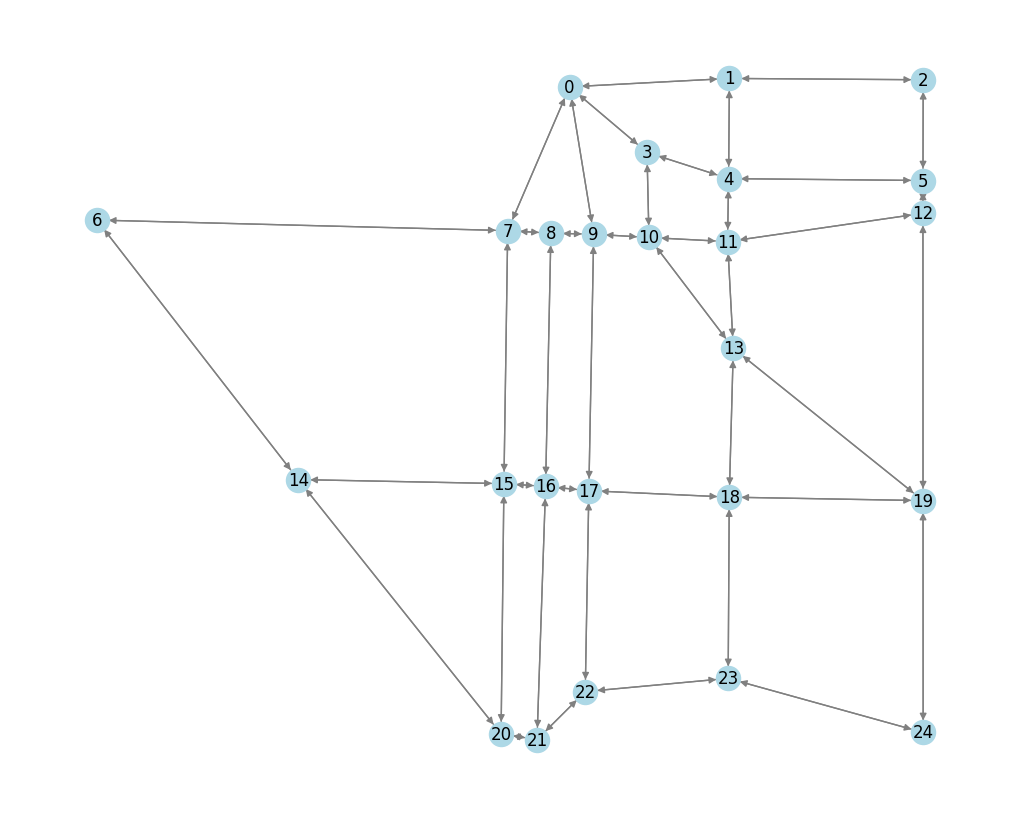

In [15]:
import numpy as np
import pandas as pd
import networkx as nx
from scipy.optimize import linprog
import matplotlib.pyplot as plt

# Load data
stations_file = "VancouverBus/stations.csv"
routes_file = "VancouverBus/routes.csv"

nodes = pd.read_csv(stations_file, index_col=0)
edges = pd.read_csv(routes_file)

# Construct directed graph
G = nx.DiGraph()
G.add_nodes_from(nodes.index)

# Add edges with weights (Euclidean distance between stations)
def euclidean_distance(node1, node2):
    x1, y1 = nodes.loc[node1, "x"], nodes.loc[node1, "y"]
    x2, y2 = nodes.loc[node2, "x"], nodes.loc[node2, "y"]
    return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

for i in edges.index:
    source, target = edges.iloc[i, 0], edges.iloc[i, 1]
    if source in nodes.index and target in nodes.index:
        distance = euclidean_distance(source, target)
        G.add_edge(source, target, weight=distance)

# Extract station names for source and destination
source_station = 0  # Downtown
target_station = 24  # MarineBoundary

# Linear Programming Formulation
num_edges = len(G.edges)
edges_list = list(G.edges)
edge_to_index = {edge: i for i, edge in enumerate(edges_list)}

# Objective function: Minimize total distance
c = np.array([G[u][v]['weight'] for u, v in edges_list])

# Constraints: Flow conservation
A_eq = np.zeros((len(G.nodes), num_edges))
b_eq = np.zeros(len(G.nodes))

for i, node in enumerate(G.nodes):
    for edge in edges_list:
        if edge[0] == node:
            A_eq[i, edge_to_index[edge]] = 1  # Outgoing edge
        if edge[1] == node:
            A_eq[i, edge_to_index[edge]] = -1  # Incoming edge
    
    if node == source_station:
        b_eq[i] = 1  # Start point
    elif node == target_station:
        b_eq[i] = -1  # End point

# Bounds: Binary constraints (0 ≤ x ≤ 1)
x_bounds = [(0, 1)] * num_edges

# Solve the LP using scipy.linprog
res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=x_bounds, method='highs')

# Extract the solution path
if res.success:
    selected_edges = [edges_list[i] for i in range(num_edges) if res.x[i] > 0.5]
    shortest_path = [source_station] + [e[1] for e in selected_edges]
    total_distance = sum(G[u][v]['weight'] for u, v in selected_edges)
    print("Shortest path from Downtown to MarineBoundary:", " -> ".join(map(str, shortest_path)))
    print("Total distance:", total_distance)
else:
    print("No feasible path found.")

# Plot the graph
plt.figure(figsize=(10, 8))
coordinates = {i: (nodes.loc[i, "x"], nodes.loc[i, "y"]) for i in nodes.index}
nx.draw(G, pos=coordinates, with_labels=True, node_color='lightblue', edge_color='gray')
plt.show()